In [5]:
from Ti import Ti

In [ ]:

print('Training Data Exp Verified by inspection')

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]
Training Data Exp Verified by inspection


In [9]:
from Ti import Ti
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.optim import Adam

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

num_items = 7
p = 5
q = 3
data = Ti.createData(num_items)

#createTestSet
testSet = Ti.createTestSet_w_Labels(num_items)
testSetException = Ti.createTestSet_w_LabelsExp(num_items,p,q,data)

#check if this is ok 
Ti.itemsToTensors(num_items)
Ti.itemsToTensorsException(num_items,p,q)
testSetExp, testLabelsExp, TDTotalExp, labelsExp = Ti.itemsToTensorsException(num_items,p,q)

Ti.createTDTotalExp(data, p, q, num_items)
Ti.createTDLabelsTotalExp(data)

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data,   dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)
        self.test_dataset = testSetExp.float()

    def __len__(self): return self.data.shape[0]
    def __getitem__(self, i): return self.data[i], self.labels[i]

TDExp = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp = Ti.createTDLabelsTotalExp(data)

print(len(TDExp), len(TDLabelsExp)) 
dataset = CustomDataset(TDExp, TDLabelsExp)
dataloader = DataLoader(dataset, batch_size=28, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1*(2*num_items), 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    
model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.MSELoss()
learning_rate = 0.01
epochs = 10000

for epoch in range(epochs):
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1))  # Make sure y has the same shape as pred

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.linear_relu_stack[2].parameters():
                param -= learning_rate * param.grad

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# eval (assuming testSetExp/testLabelsExp are aligned tensors/arrays)
test_dataset = CustomDataset(testSetExp, testLabelsExp)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)
model.eval()
preds, trues = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        p = model(X).squeeze(1).cpu()
        preds.extend(p.tolist()); trues.extend(y.tolist())

pred_labels = [1 if v>=0 else -1 for v in preds]
acc = sum(int(p==t) for p,t in zip(pred_labels, trues)) / len(trues)
print(f"Accuracy: {acc:.4f}")

Using cpu device
0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6
testSetException: [[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0

In [10]:
pred_labels

[-1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [12]:
# Reads out test labels and model output

# testLabelsExp.reshape(num_items,num_items)
# model(testSetExp.float()).reshape(num_items,num_items)

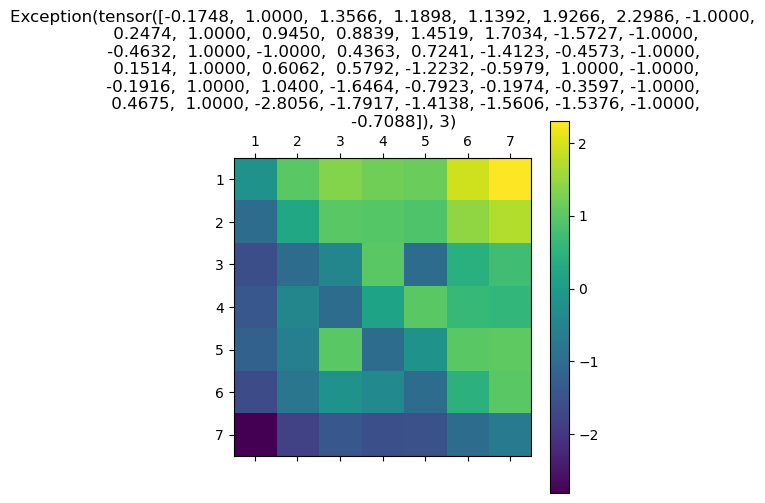

In [11]:
import matplotlib.pyplot as plt

# Assuming `model` and `testSet` are already defined
output = model(testSetExp.float()).reshape(num_items, num_items).detach()

# Plot the matrix with axes starting at 1
plt.matshow(output)

plt.title(f'Exception{p,q}')
# Modify the ticks to start from 1
plt.xticks(range(num_items), range(1, num_items + 1))
plt.yticks(range(num_items), range(1, num_items + 1))

plt.colorbar()  # Optional: to add a color bar for reference
plt.show()

# Small network to get the optimal lr

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]
[Run 00] Step 0 MSE: 1.035815


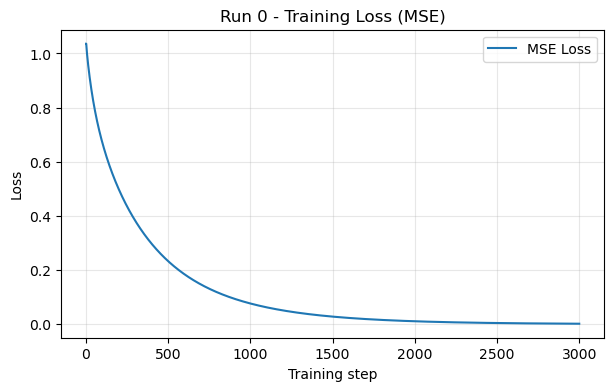

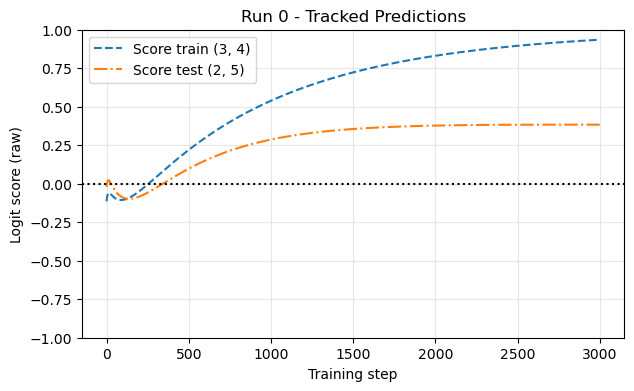

[Run 01] Step 0 MSE: 1.023759


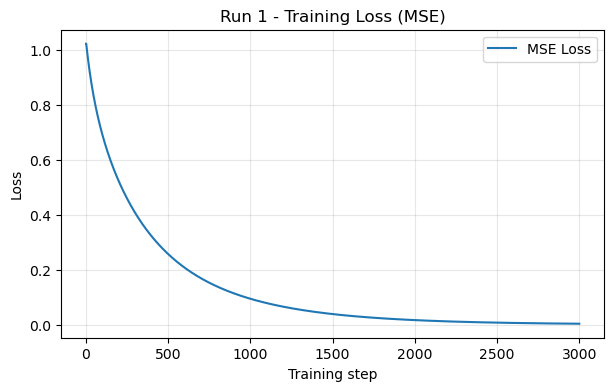

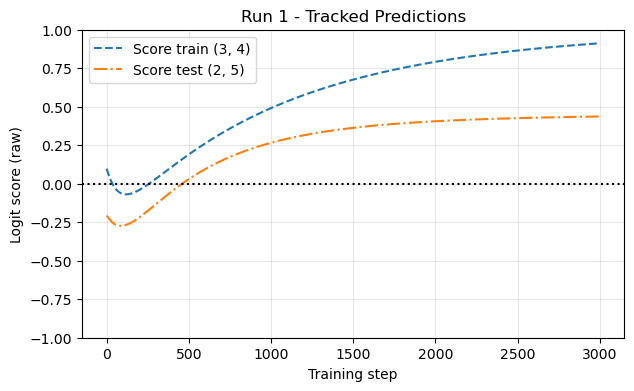

[Run 02] Step 0 MSE: 1.003114


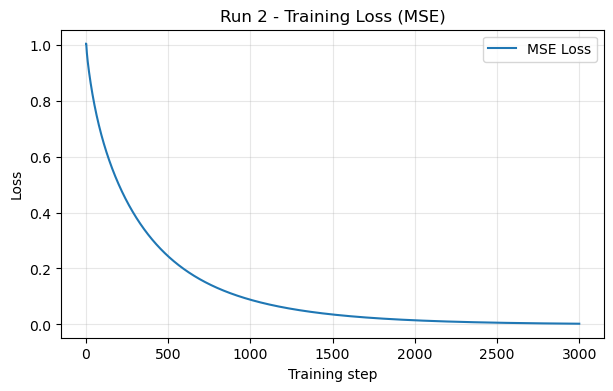

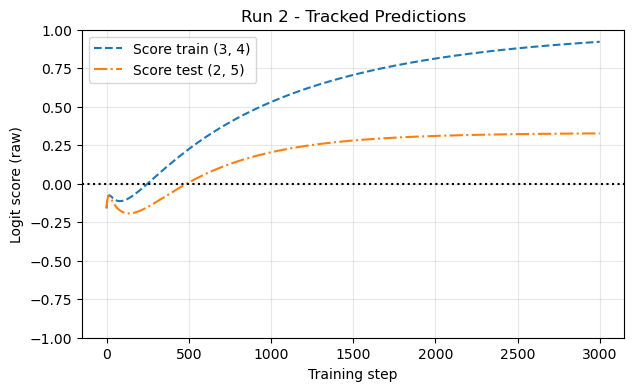

[Run 03] Step 0 MSE: 0.994618


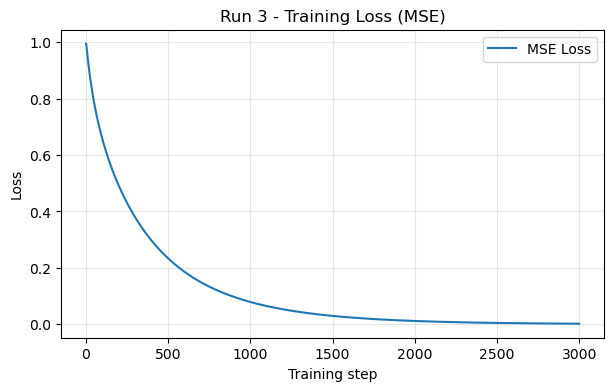

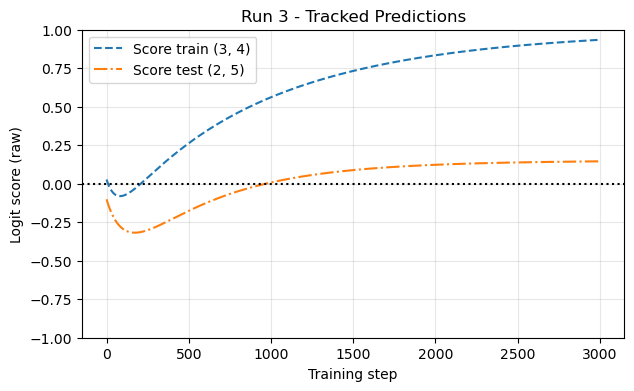

[Run 04] Step 0 MSE: 1.012300


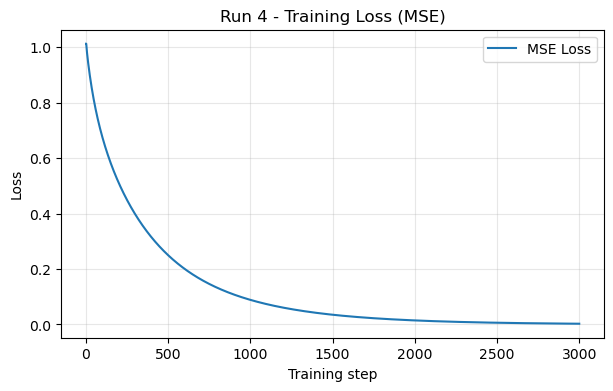

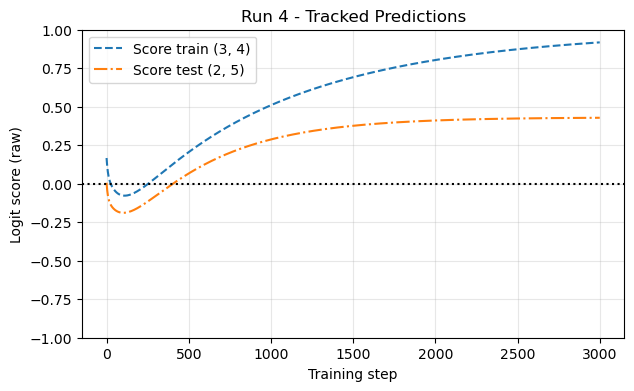

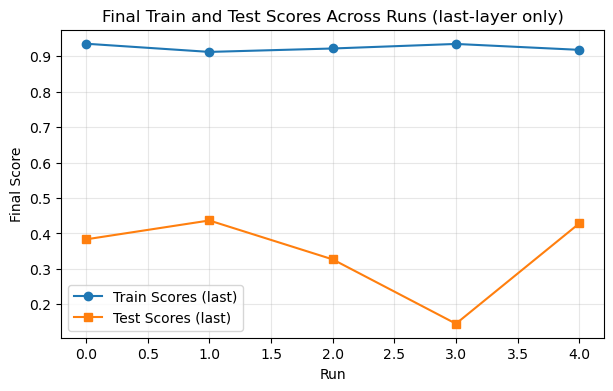

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Model: name layers explicitly
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n, hidden=3000):
        super().__init__()
        self.fc1 = nn.Linear(2*n, hidden)  # will be FROZEN
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)    # ONLY layer we train

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7
p, q = 5, 3

# Your data creators
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

runs = 5
epochs = 5000
loss_fn = nn.MSELoss()

for run in range(runs):
    # fresh model each run
    model = NeuralNetwork(num_items, hidden=3000).to(device)

    # Freeze first layer (random features)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer
    opt = torch.optim.SGD(model.fc2.parameters(), lr=1e-3)

    # Tracked pairs
    train_pair = (q, q+1)   # (2,3)
    test_pair  = (q-1, p)   # (1,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer is trainable)
    model.train()
    for epoch in range(epochs):
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)

    # ---- Plots per run (optional; comment out to speed up) ----
    steps = range(len(loss_history))

    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


[x] lr=1e-3 works for n = 3000, 5000 epochs

[x] lr=1e-4 works for n = 50000, 5000 epochs

[] lr=1e-3 doesn't work for n = 50000, 5000 epochs

In [45]:
m = 50000
print(1/np.sqrt(m))

0.00447213595499958


inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]


Runs:   0%|          | 0/5 [00:00<?, ?it/s]

[Run 00] Step 0 MSE: 1.053995


Run 0:   0%|          | 0/5000 [00:00<?, ?it/s]

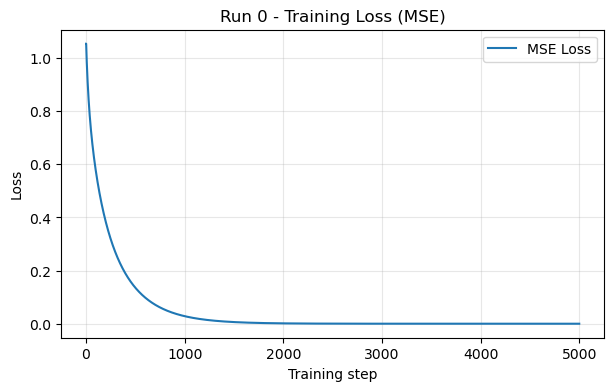

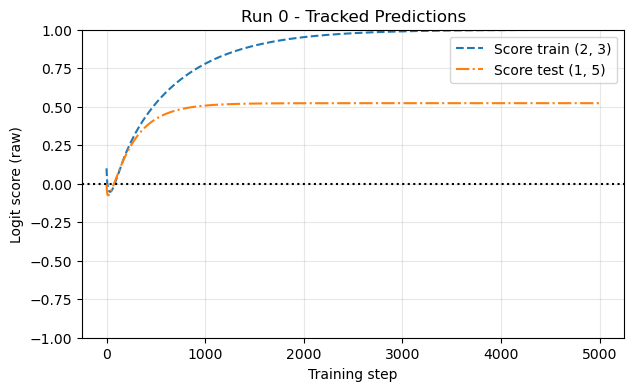

Runs:  20%|██        | 1/5 [01:44<06:56, 104.00s/it]

[Run 01] Step 0 MSE: 1.033605


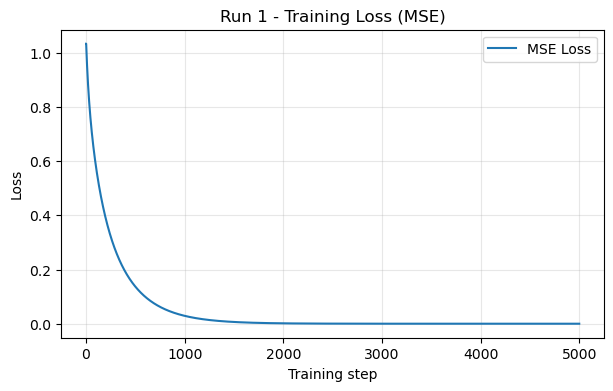

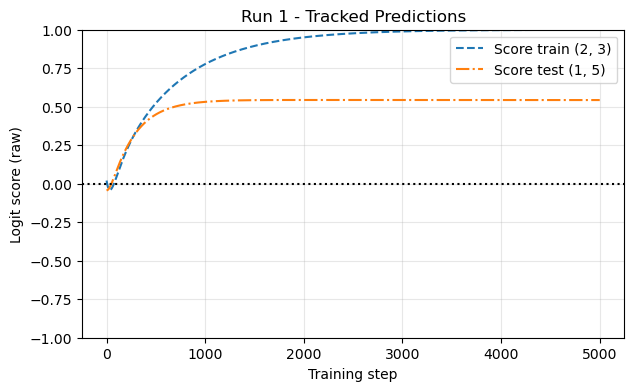

Runs:  40%|████      | 2/5 [03:16<04:52, 97.42s/it] 

[Run 02] Step 0 MSE: 1.009434


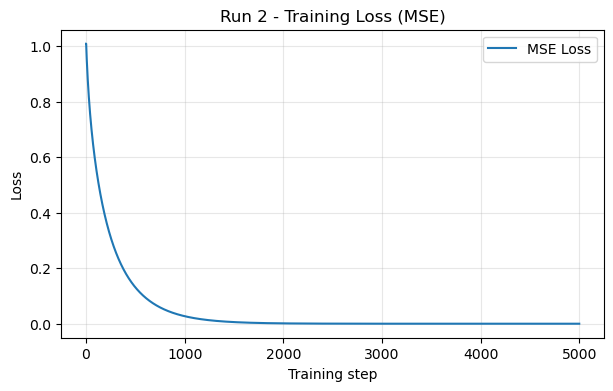

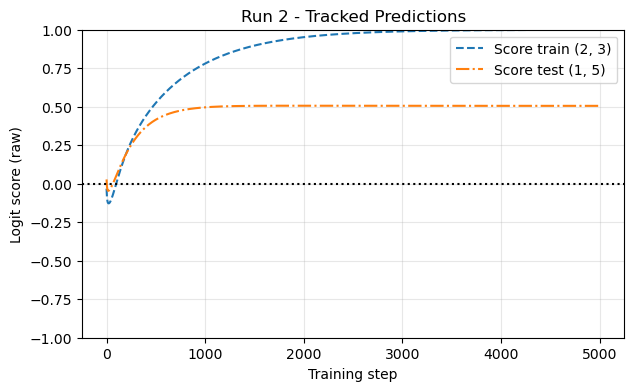

Runs:  60%|██████    | 3/5 [04:43<03:05, 92.56s/it]

[Run 03] Step 0 MSE: 1.030920


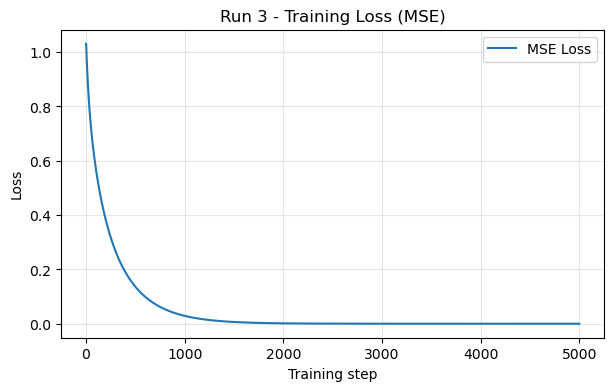

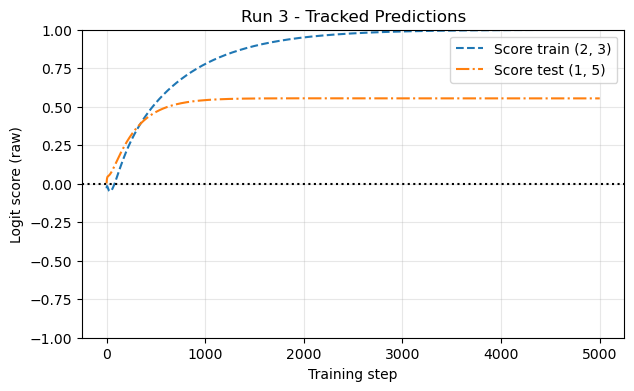

Runs:  80%|████████  | 4/5 [06:09<01:30, 90.11s/it]

[Run 04] Step 0 MSE: 1.005285


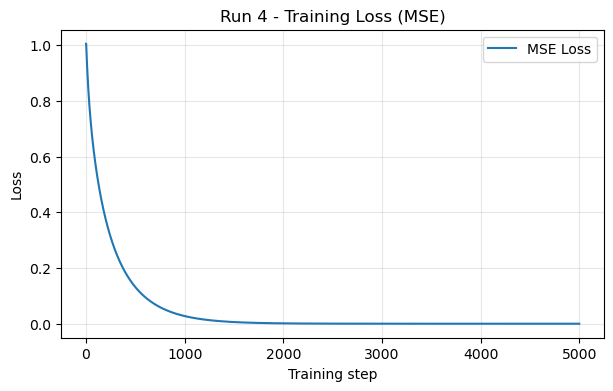

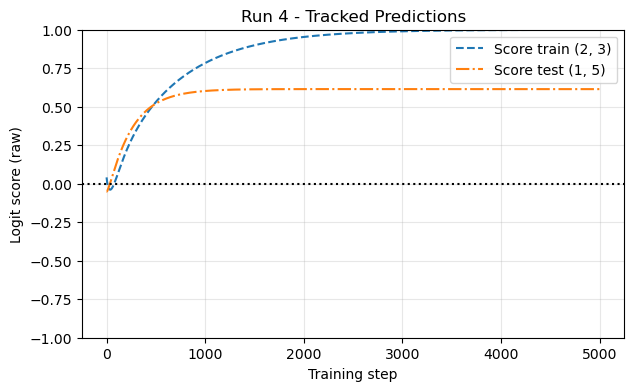

Runs: 100%|██████████| 5/5 [07:15<00:00, 87.15s/it]


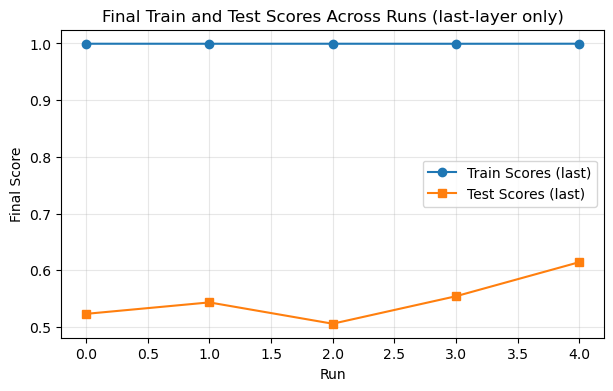

In [50]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Model: name layers explicitly
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n, hidden=50000):
        super().__init__()
        self.fc1 = nn.Linear(2*n, hidden)  # will be FROZEN
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)    # ONLY layer we train

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7
p, q = 5, 2

# Your data creators
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

runs = 5
epochs = 5000
loss_fn = nn.MSELoss()

for run in tqdm(range(runs), desc="Runs", position=0):
    # fresh model each run
    model = NeuralNetwork(num_items, hidden=50000).to(device)

    # Freeze first layer (random features)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer
    # Option A: SGD + momentum (stable)
    opt = torch.optim.SGD(model.fc2.parameters(), lr = 1e-4)
    # Option B: AdamW (uncomment to try)
    # opt = torch.optim.AdamW(model.fc2.parameters(), lr=1e-3, weight_decay=1e-4)

    # Tracked pairs
    train_pair = (q, q+1)   # (2,3)
    test_pair  = (q-1, p)   # (1,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer is trainable)
    model.train()
    epoch_bar = tqdm(range(epochs), desc=f"Run {run}", position=1, leave=False)
    for epoch in epoch_bar:
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)
        
        # Update progress bar with current loss
        if len(loss_history) > 0:
            epoch_bar.set_postfix(loss=f"{loss_history[-1]:.6f}")
    
    epoch_bar.close()

    # ---- Plots per run (optional; comment out to speed up) ----
    steps = range(len(loss_history))

    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]


Runs:   0%|          | 0/3 [00:00<?, ?it/s]

[Run 00] Step 0 MSE: 1.043694


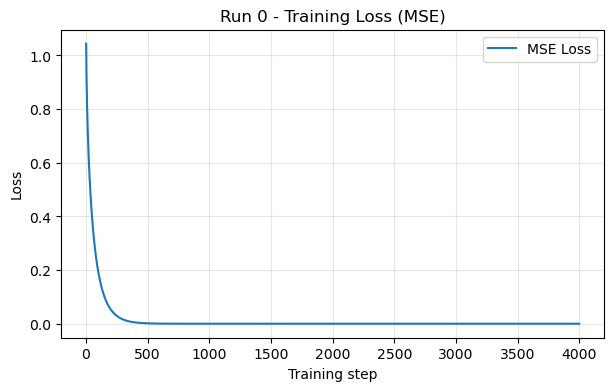

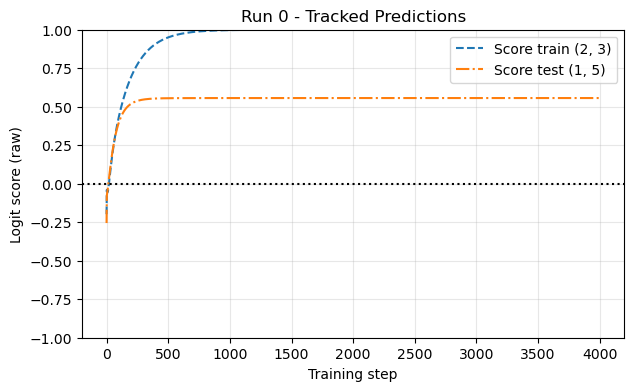

Runs:  33%|███▎      | 1/3 [01:44<03:28, 104.41s/it]

[Run 01] Step 0 MSE: 1.008334


Runs:  33%|███▎      | 1/3 [01:58<03:56, 118.03s/it]


KeyboardInterrupt: 

In [51]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Model: name layers explicitly
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n, hidden=200000):
        super().__init__()
        self.fc1 = nn.Linear(2*n, hidden)  # will be FROZEN
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)    # ONLY layer we train

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7
p, q = 5, 2

# Your data creators
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

runs = 3
epochs = 4000
loss_fn = nn.MSELoss()

for run in tqdm(range(runs), desc="Runs", position=0):
    # fresh model each run
    model = NeuralNetwork(num_items, hidden=200000).to(device)

    # Freeze first layer (random features)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer
    # Option A: SGD + momentum (stable)
    opt = torch.optim.SGD(model.fc2.parameters(), lr = 1e-4)
    # Option B: AdamW (uncomment to try)
    # opt = torch.optim.AdamW(model.fc2.parameters(), lr=1e-3, weight_decay=1e-4)

    # Tracked pairs
    train_pair = (q, q+1)   # (2,3)
    test_pair  = (q-1, p)   # (1,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer is trainable)
    model.train()
    epoch_bar = tqdm(range(epochs), desc=f"Run {run}", position=1, leave=False)
    for epoch in epoch_bar:
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)
        
        # Update progress bar with current loss
        if len(loss_history) > 0:
            epoch_bar.set_postfix(loss=f"{loss_history[-1]:.6f}")
    
    epoch_bar.close()

    # ---- Plots per run (optional; comment out to speed up) ----
    steps = range(len(loss_history))

    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# Only 1000 epochs needed

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]


Runs:   0%|          | 0/3 [00:00<?, ?it/s]

[Run 00] Step 0 MSE: 1.043694


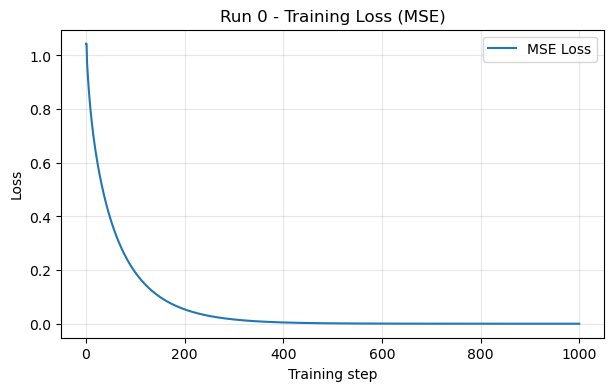

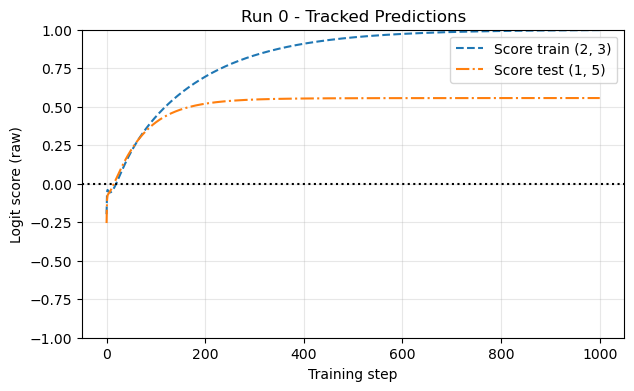

Runs:  33%|███▎      | 1/3 [00:20<00:40, 20.27s/it]

[Run 01] Step 0 MSE: 1.008334


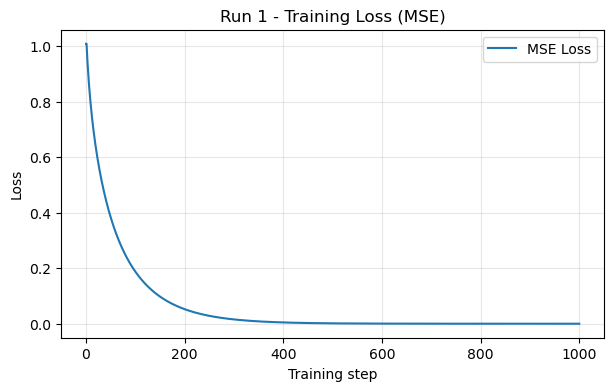

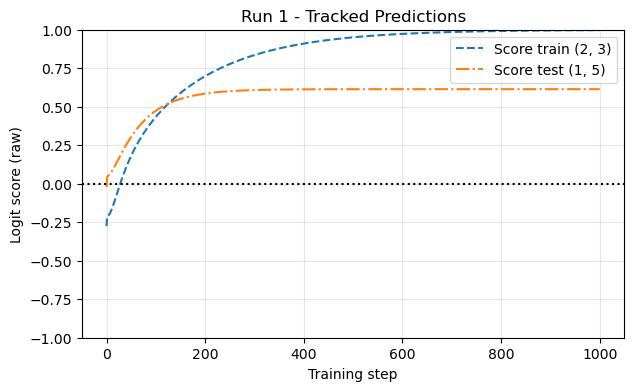

Runs:  67%|██████▋   | 2/3 [00:39<00:19, 19.92s/it]

[Run 02] Step 0 MSE: 1.002804


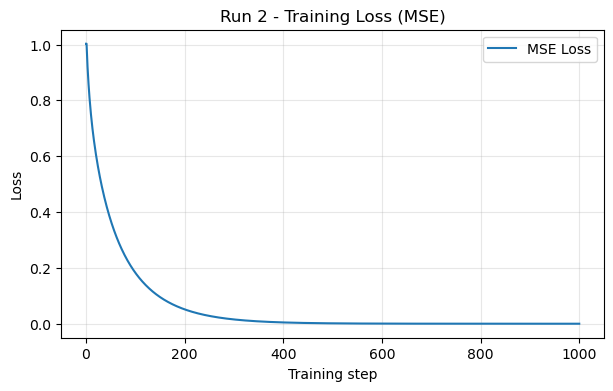

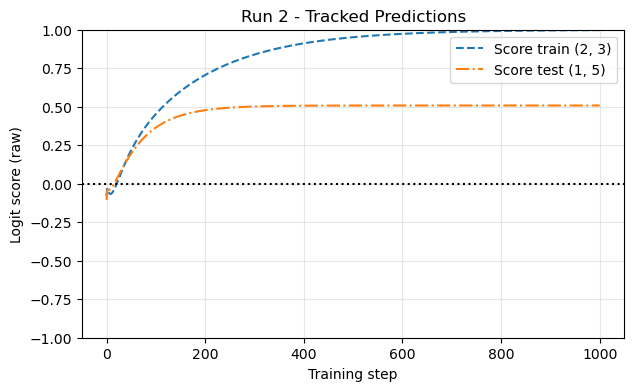

Runs: 100%|██████████| 3/3 [01:00<00:00, 20.31s/it]


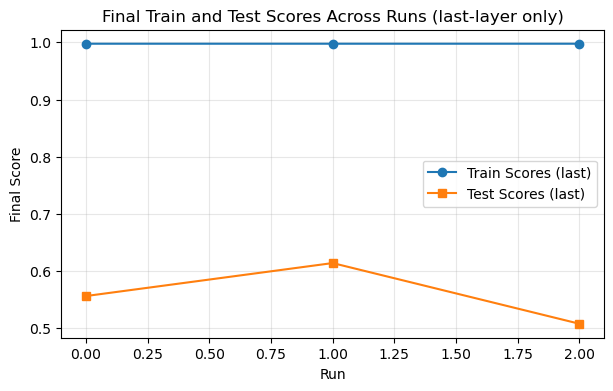

In [52]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Model: name layers explicitly
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n, hidden=200000):
        super().__init__()
        self.fc1 = nn.Linear(2*n, hidden)  # will be FROZEN
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)    # ONLY layer we train

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7
p, q = 5, 2

# Your data creators
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

runs = 3
epochs = 1000
loss_fn = nn.MSELoss()

for run in tqdm(range(runs), desc="Runs", position=0):
    # fresh model each run
    model = NeuralNetwork(num_items, hidden=200000).to(device)

    # Freeze first layer (random features)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer
    # Option A: SGD + momentum (stable)
    opt = torch.optim.SGD(model.fc2.parameters(), lr = 1e-4)
    # Option B: AdamW (uncomment to try)
    # opt = torch.optim.AdamW(model.fc2.parameters(), lr=1e-3, weight_decay=1e-4)

    # Tracked pairs
    train_pair = (q, q+1)   # (2,3)
    test_pair  = (q-1, p)   # (1,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer is trainable)
    model.train()
    epoch_bar = tqdm(range(epochs), desc=f"Run {run}", position=1, leave=False)
    for epoch in epoch_bar:
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)
        
        # Update progress bar with current loss
        if len(loss_history) > 0:
            epoch_bar.set_postfix(loss=f"{loss_history[-1]:.6f}")
    
    epoch_bar.close()

    # ---- Plots per run (optional; comment out to speed up) ----
    steps = range(len(loss_history))

    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]
[Step 0] Initial MSE loss: 1.092993


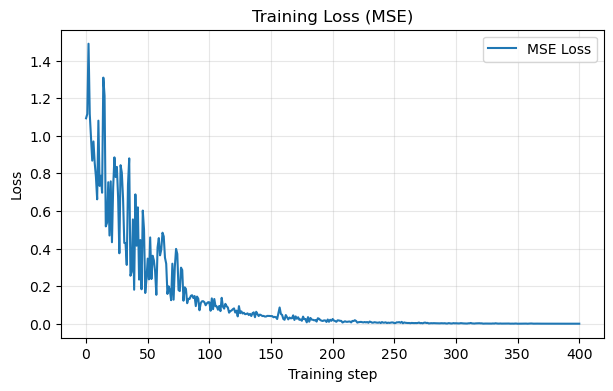

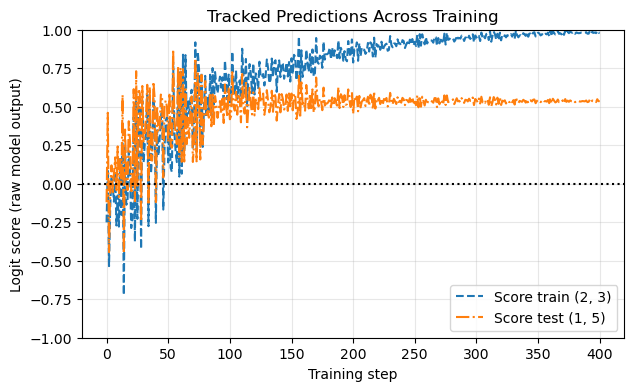

[Step 0] Initial MSE loss: 1.016314


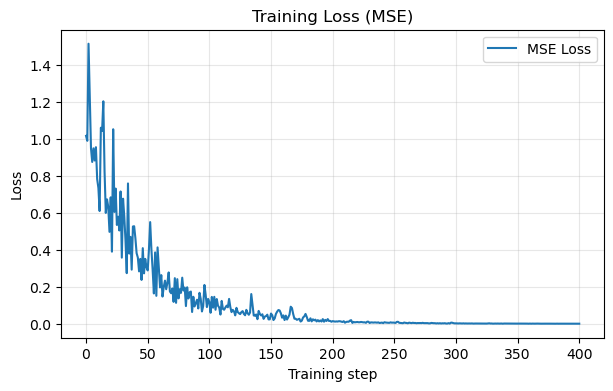

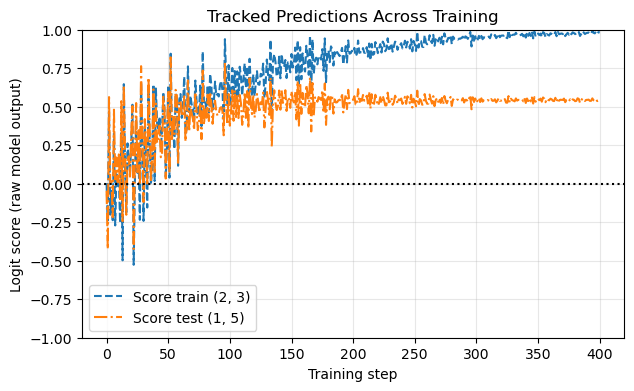

[Step 0] Initial MSE loss: 1.014636


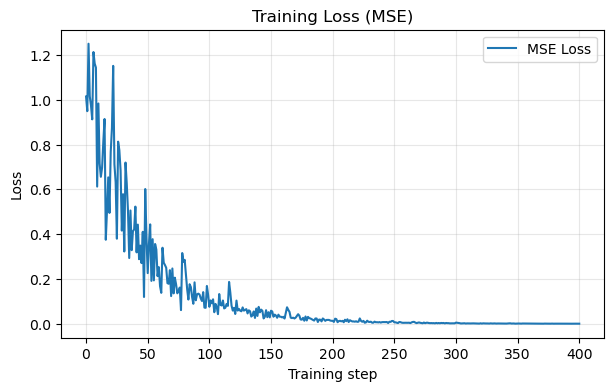

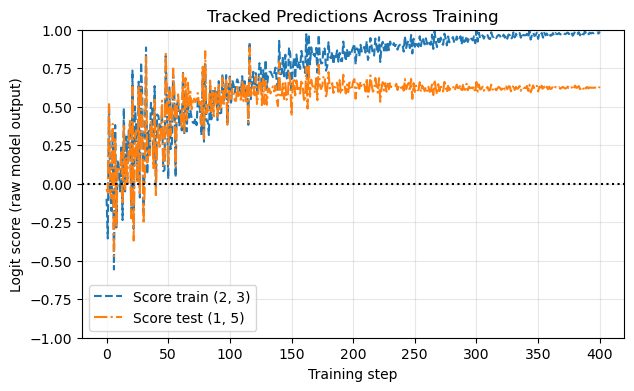

[Step 0] Initial MSE loss: 0.998231


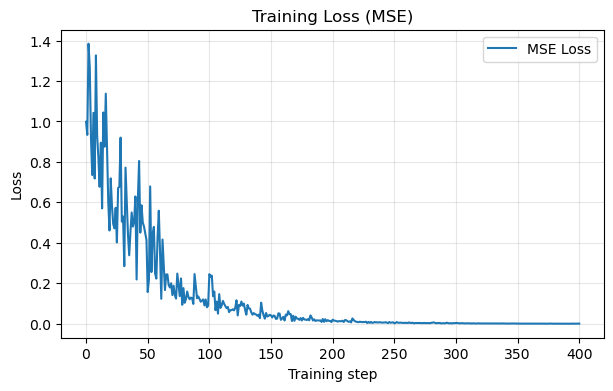

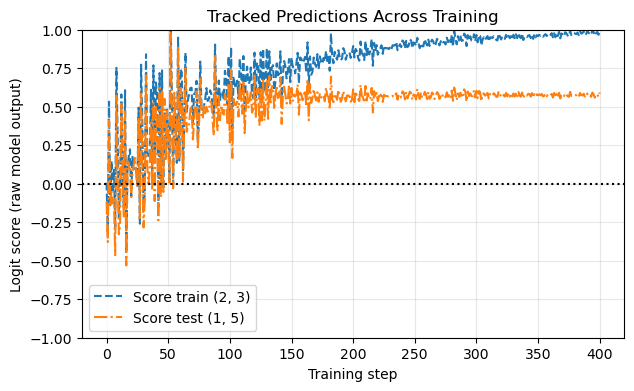

[Step 0] Initial MSE loss: 0.951889


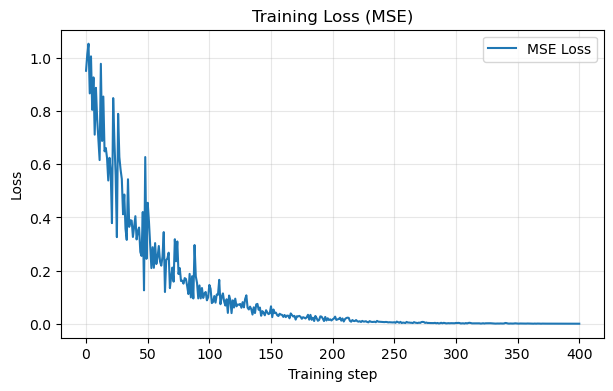

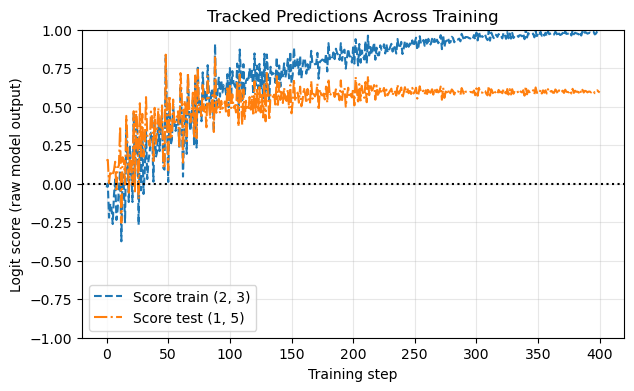

[Step 0] Initial MSE loss: 1.000003


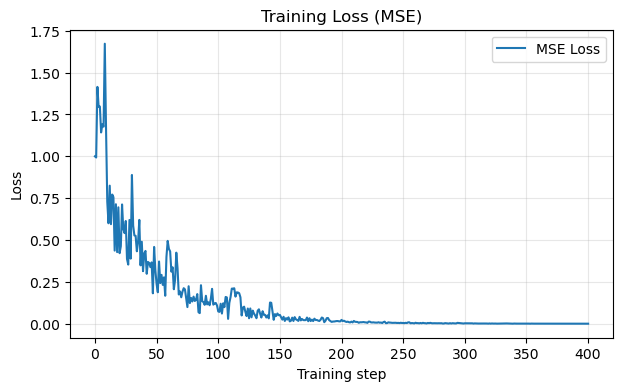

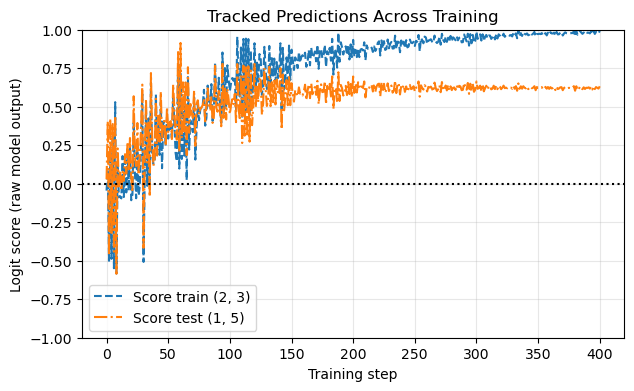

[Step 0] Initial MSE loss: 1.088922


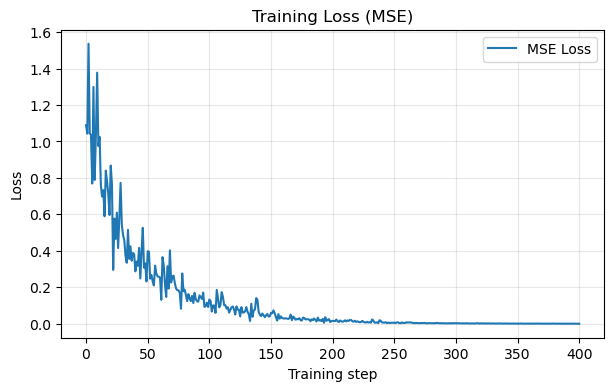

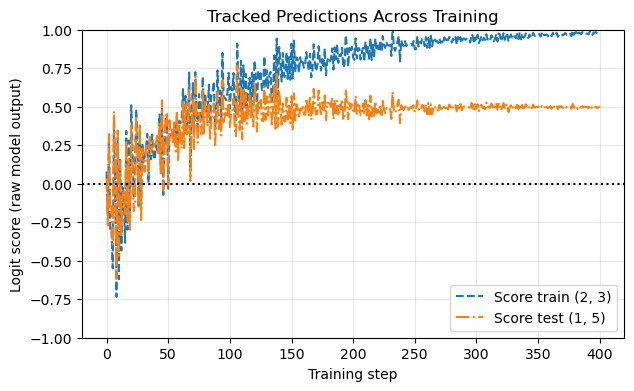

[Step 0] Initial MSE loss: 0.996897


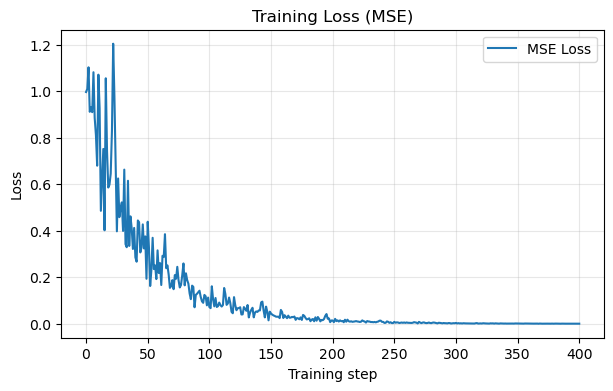

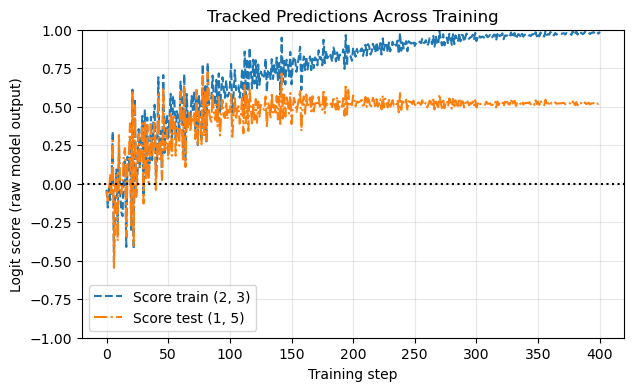

[Step 0] Initial MSE loss: 1.051342


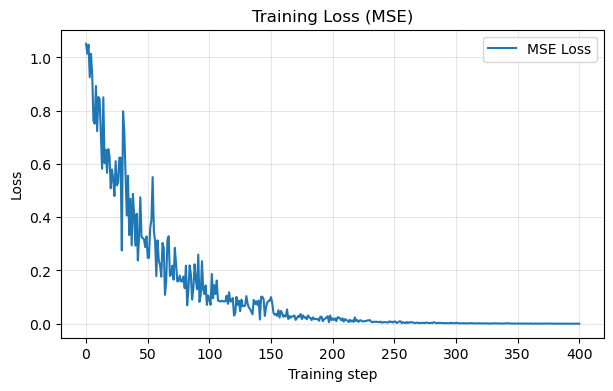

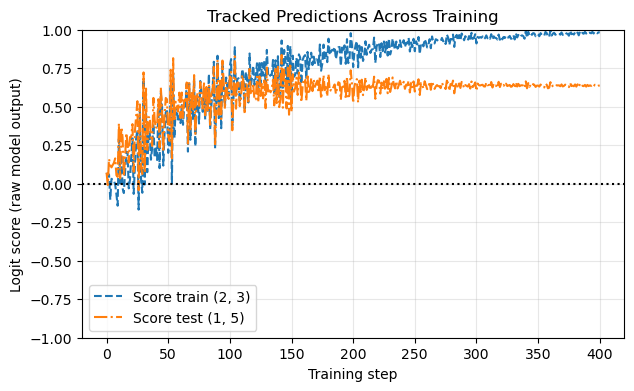

[Step 0] Initial MSE loss: 1.014703


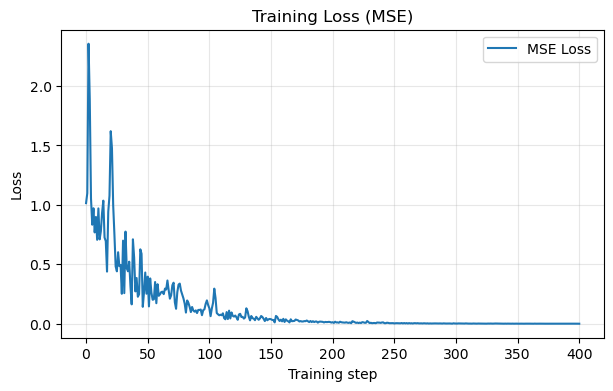

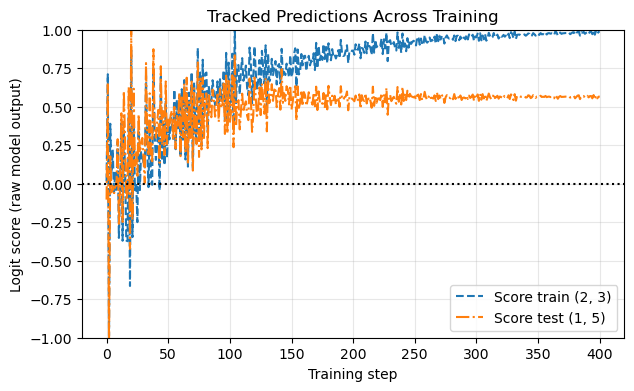

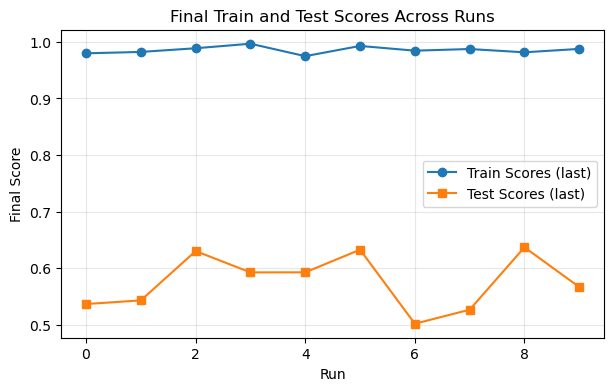

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import matplotlib.pyplot as plt

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def show_adjacent_results(model, n):
    dev = next(model.parameters()).device
    with torch.no_grad():
        for j in range(1, n):
            x = pair_vec_1based(j, j+1, n).to(dev).unsqueeze(0)
            logit = model(x).item()
            pred  = 1 if logit >= 0 else -1
            print(f"( {j},{j+1} )  logit={logit:+.4f}  pred={pred}")

def score_and_label_from_logits(logits):
    """Return raw score and ±1 prediction from a logit tensor."""
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Example model: simple linear+relu+linear
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2*n, 100000),
            nn.ReLU(),
            nn.Linear(100000, 1),
        )
    def forward(self, x): return self.net(x)

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7  # length of each one-hot
p, q = 5, 2    # example values


# -----------------------------
# Run model man times
# -----------------------------


TDExp = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

train_scores_last = []
test_scores_last = []

for i in range(10):

    model = NeuralNetwork(num_items).to(device)
    loss_fn = nn.MSELoss()
    #use sgd
    opt = torch.optim.SGD(model.parameters(), lr=3e-4)

    # -----------------------------
    # Tracking setup
    # -----------------------------
    train_pair = (q, q+1)   # (2,3) in this example
    test_pair  = (q-1, p)   # (1,5) in this example

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        all_X, all_y = next(iter(dataloader))
        all_X, all_y = all_X.to(device), all_y.to(device).view(-1)
        init_pred = model(all_X).view(-1)
        init_loss = loss_fn(init_pred, all_y).item()
        loss_history.append(init_loss)
        # also initial tracked scores
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr)
        test_scores.append(s_te)
    print(f"[Step 0] Initial MSE loss: {init_loss:.6f}")

    # -----------------------------
    # Training loop
    # -----------------------------
    epochs = 200
    model.train()
    for epoch in range(epochs):
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1)
            pred = model(X).view(-1)
            loss = loss_fn(pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            # record loss
            loss_history.append(loss.item())

            # record tracked scores
            with torch.no_grad():
                # Track raw logits (no activation) for SGD
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr)
                test_scores.append(s_te)

    # -----------------------------
    # Plotting
    # -----------------------------
    steps = range(len(loss_history))

    # Figure 1: Loss only
    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.title("Training Loss (MSE)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Figure 2: Predictions (raw logits) for chosen pairs
    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores, '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step")
    plt.ylabel("Logit score (raw model output)")
    plt.title("Tracked Predictions Across Training")
    plt.axhline(0, color='k', linestyle=':')  # decision boundary
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)
    plt.legend()
    plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])    

plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run")
plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]


Runs:   0%|          | 0/3 [00:00<?, ?it/s]

[Run 00] Step 0 MSE: 0.958347


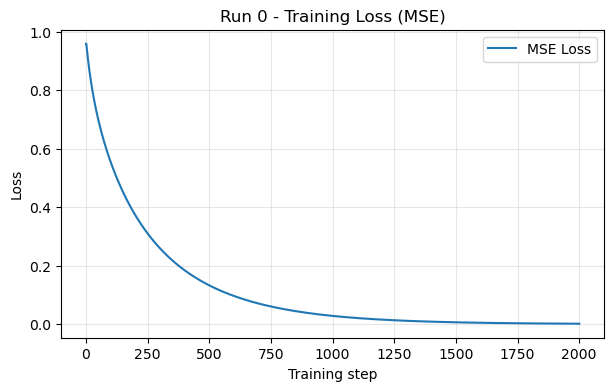

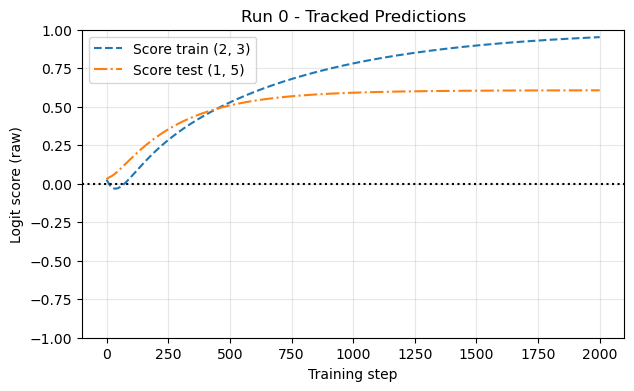

Runs:  33%|███▎      | 1/3 [01:21<02:43, 81.78s/it]

[Run 01] Step 0 MSE: 1.007251


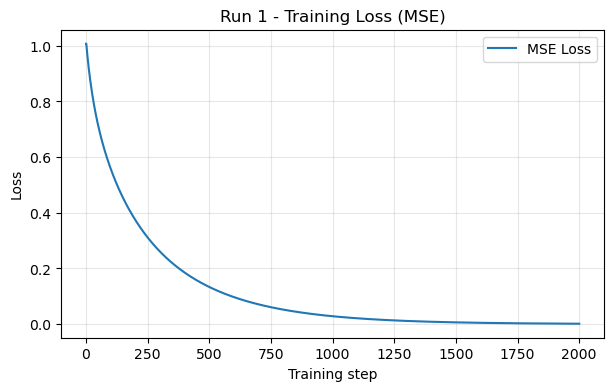

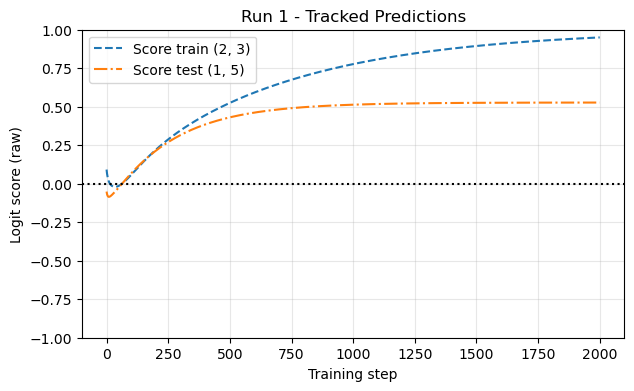

Runs:  67%|██████▋   | 2/3 [02:31<01:14, 74.97s/it]

[Run 02] Step 0 MSE: 0.982543


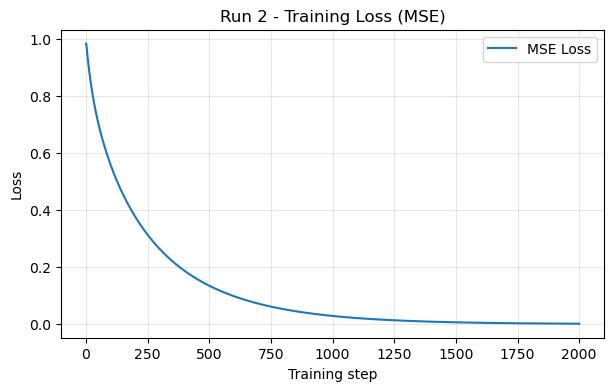

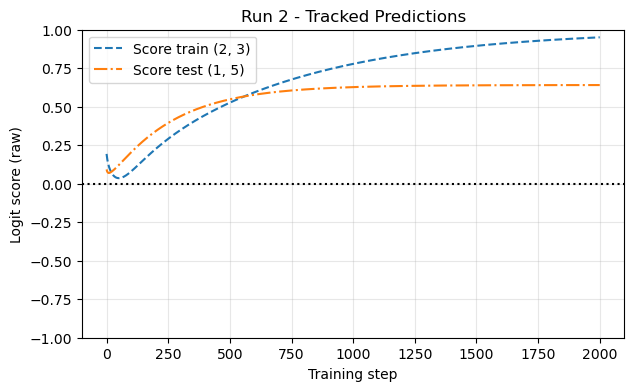

Runs: 100%|██████████| 3/3 [03:45<00:00, 75.08s/it]


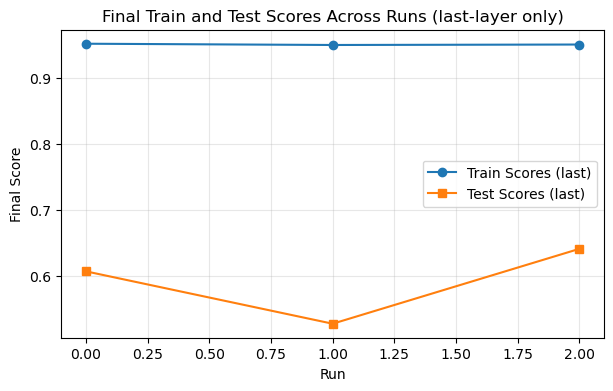

In [54]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Model: name layers explicitly
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n, hidden=500000):
        super().__init__()
        self.fc1 = nn.Linear(2*n, hidden)  # will be FROZEN
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)    # ONLY layer we train

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7
p, q = 5, 2

# Your data creators
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

runs = 3
epochs = 2000
loss_fn = nn.MSELoss()

for run in tqdm(range(runs), desc="Runs", position=0):
    # fresh model each run
    model = NeuralNetwork(num_items, hidden=500000).to(device)

    # Freeze first layer (random features)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer
    # Option A: SGD + momentum (stable)
    opt = torch.optim.SGD(model.fc2.parameters(), lr = 1e-5)
    # Option B: AdamW (uncomment to try)
    # opt = torch.optim.AdamW(model.fc2.parameters(), lr=1e-3, weight_decay=1e-4)

    # Tracked pairs
    train_pair = (q, q+1)   # (2,3)
    test_pair  = (q-1, p)   # (1,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer is trainable)
    model.train()
    epoch_bar = tqdm(range(epochs), desc=f"Run {run}", position=1, leave=False)
    for epoch in epoch_bar:
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)
        
        # Update progress bar with current loss
        if len(loss_history) > 0:
            epoch_bar.set_postfix(loss=f"{loss_history[-1]:.6f}")
    
    epoch_bar.close()

    # ---- Plots per run (optional; comment out to speed up) ----
    steps = range(len(loss_history))

    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# 500,000 with lr=1e-6 gives you the most stable yet

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]


Runs:   0%|          | 0/3 [00:00<?, ?it/s]

[Run 00] Step 0 MSE: 0.970253


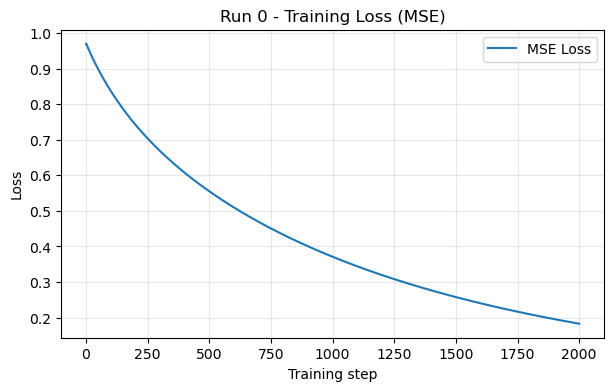

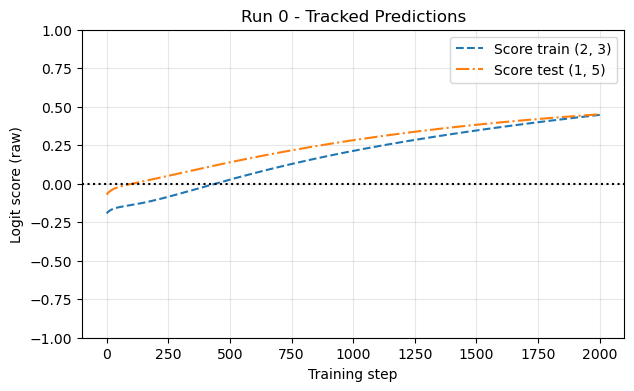

Runs:  33%|███▎      | 1/3 [02:13<04:27, 133.68s/it]

[Run 01] Step 0 MSE: 1.030791


Runs:  33%|███▎      | 1/3 [02:34<05:08, 154.23s/it]


KeyboardInterrupt: 

In [55]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Model: name layers explicitly
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n, hidden=1000000):
        super().__init__()
        self.fc1 = nn.Linear(2*n, hidden)  # will be FROZEN
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)    # ONLY layer we train

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7
p, q = 5, 2

# Your data creators
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

runs = 3
epochs = 2000
loss_fn = nn.MSELoss()

for run in tqdm(range(runs), desc="Runs", position=0):
    # fresh model each run
    model = NeuralNetwork(num_items, hidden=1000000).to(device)

    # Freeze first layer (random features)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer
    # Option A: SGD + momentum (stable)
    opt = torch.optim.SGD(model.fc2.parameters(), lr = 1e-6)
    # Option B: AdamW (uncomment to try)
    # opt = torch.optim.AdamW(model.fc2.parameters(), lr=1e-3, weight_decay=1e-4)

    # Tracked pairs
    train_pair = (q, q+1)   # (2,3)
    test_pair  = (q-1, p)   # (1,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer is trainable)
    model.train()
    epoch_bar = tqdm(range(epochs), desc=f"Run {run}", position=1, leave=False)
    for epoch in epoch_bar:
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)
        
        # Update progress bar with current loss
        if len(loss_history) > 0:
            epoch_bar.set_postfix(loss=f"{loss_history[-1]:.6f}")
    
    epoch_bar.close()

    # ---- Plots per run (optional; comment out to speed up) ----
    steps = range(len(loss_history))

    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]


Runs:   0%|          | 0/3 [00:00<?, ?it/s]

[Run 00] Step 0 MSE: 1.000225


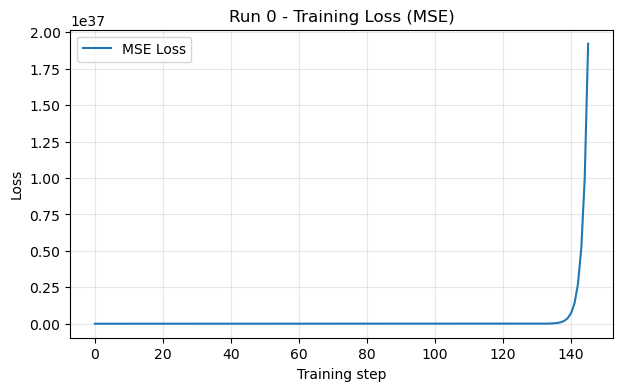

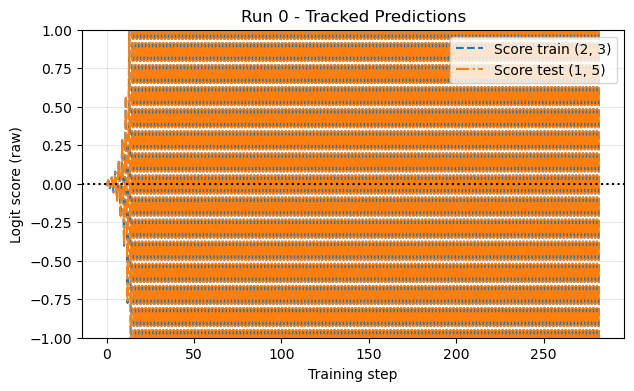

Runs:  33%|███▎      | 1/3 [05:49<11:38, 349.11s/it]

[Run 01] Step 0 MSE: 1.003366


Runs:  33%|███▎      | 1/3 [05:58<11:56, 358.44s/it]


KeyboardInterrupt: 

In [58]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Model: name layers explicitly
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n, hidden=1000000):
        super().__init__()
        self.fc1 = nn.Linear(2*n, hidden)  # will be FROZEN
        with torch.no_grad():
            self.fc1.weight.data /= np.sqrt(2*1000000)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)    # ONLY layer we train

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7
p, q = 5, 2

# Your data creators
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

runs = 3
epochs = 5000
loss_fn = nn.MSELoss()

for run in tqdm(range(runs), desc="Runs", position=0):
    # fresh model each run
    model = NeuralNetwork(num_items, hidden=1000000).to(device)

    # Freeze first layer (random features)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer
    # Option A: SGD + momentum (stable)
    opt = torch.optim.SGD(model.fc2.parameters(), lr = 1e-4)
    # Option B: AdamW (uncomment to try)
    # opt = torch.optim.AdamW(model.fc2.parameters(), lr=1e-3, weight_decay=1e-4)

    # Tracked pairs
    train_pair = (q, q+1)   # (2,3)
    test_pair  = (q-1, p)   # (1,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer is trainable)
    model.train()
    epoch_bar = tqdm(range(epochs), desc=f"Run {run}", position=1, leave=False)
    for epoch in epoch_bar:
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)
        
        # Update progress bar with current loss
        if len(loss_history) > 0:
            epoch_bar.set_postfix(loss=f"{loss_history[-1]:.6f}")
    
    epoch_bar.close()

    # ---- Plots per run (optional; comment out to speed up) ----
    steps = range(len(loss_history))

    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]


Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 1/50000 [00:00<5:38:51,  2.46it/s, epoch=1/10000, loss=0.970253, run=1/5]

[Run 00] Step 0 MSE: 0.970253


Training Progress:  20%|██        | 10000/50000 [08:57<42:17, 15.76it/s, epoch=10000/10000, loss=0.001374, run=1/5]

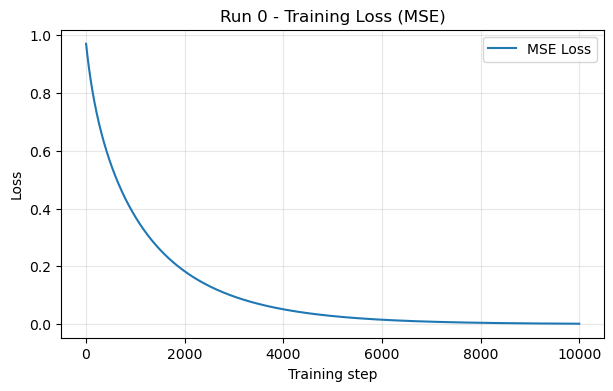

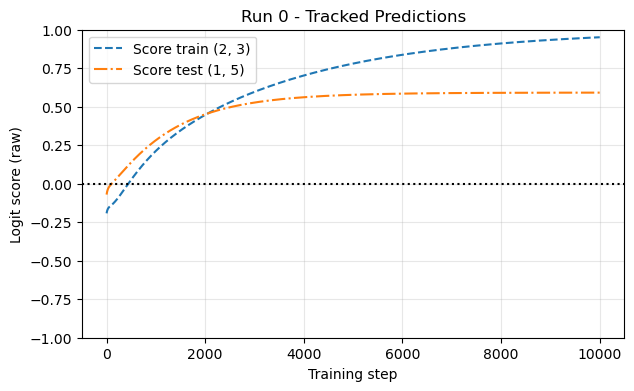

Training Progress:  20%|██        | 10003/50000 [08:58<2:05:59,  5.29it/s, epoch=3/10000, loss=1.026567, run=2/5]  

[Run 01] Step 0 MSE: 1.030791


Training Progress:  40%|████      | 20000/50000 [16:52<22:40, 22.05it/s, epoch=10000/10000, loss=0.001411, run=2/5] 

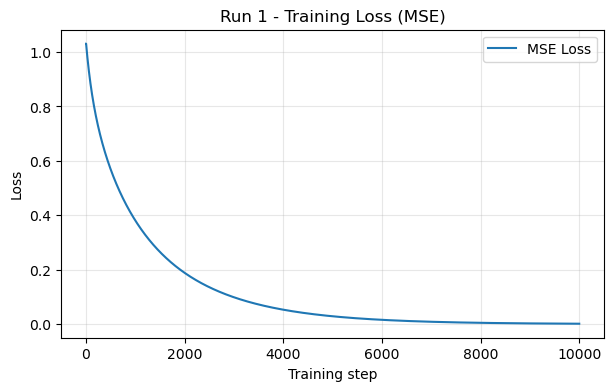

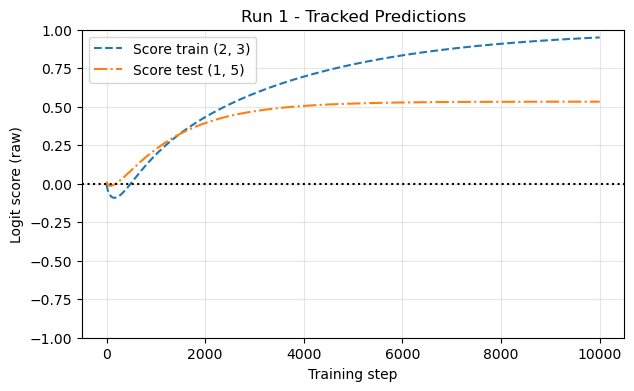

Training Progress:  40%|████      | 20003/50000 [16:53<59:35,  8.39it/s, epoch=3/10000, loss=0.973788, run=3/5]    

[Run 02] Step 0 MSE: 0.977334


Training Progress:  60%|██████    | 30000/50000 [24:42<13:49, 24.12it/s, epoch=10000/10000, loss=0.001415, run=3/5] 

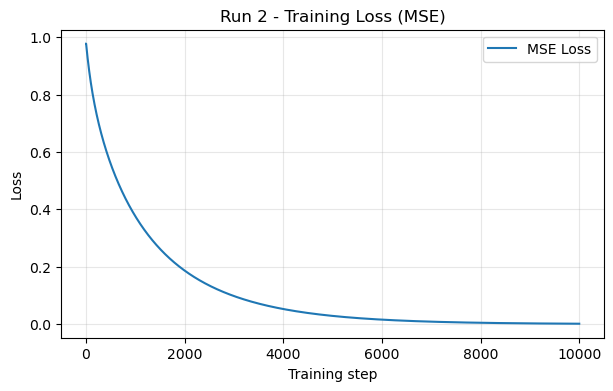

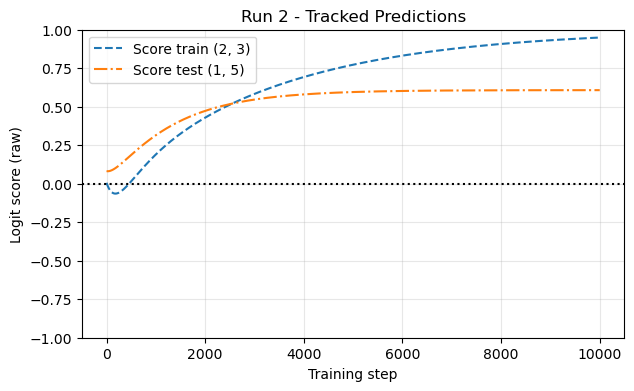

Training Progress:  60%|██████    | 30005/50000 [24:43<38:04,  8.75it/s, epoch=5/10000, loss=1.009903, run=4/5]    

[Run 03] Step 0 MSE: 1.017208


Training Progress:  80%|████████  | 40000/50000 [32:22<06:54, 24.12it/s, epoch=10000/10000, loss=0.001428, run=4/5]

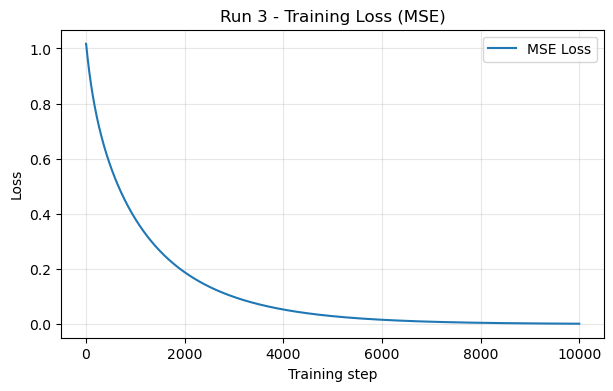

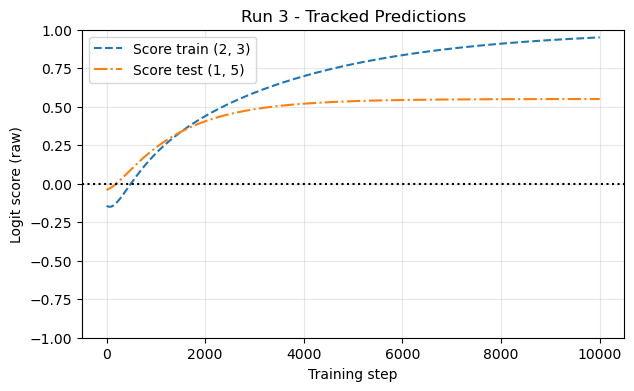

Training Progress:  80%|████████  | 40005/50000 [32:23<15:12, 10.95it/s, epoch=5/10000, loss=1.007906, run=5/5]    

[Run 04] Step 0 MSE: 1.017312


Training Progress: 100%|██████████| 50000/50000 [40:33<00:00, 23.74it/s, epoch=10000/10000, loss=0.001420, run=5/5]

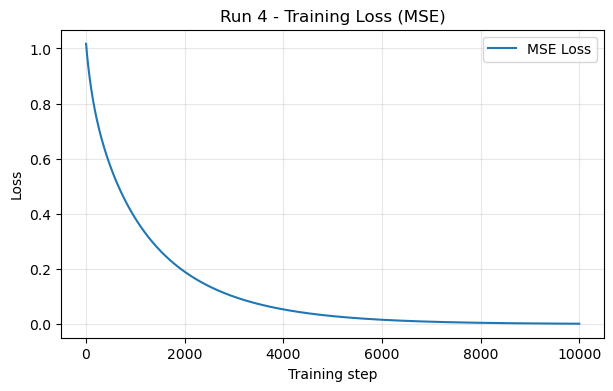

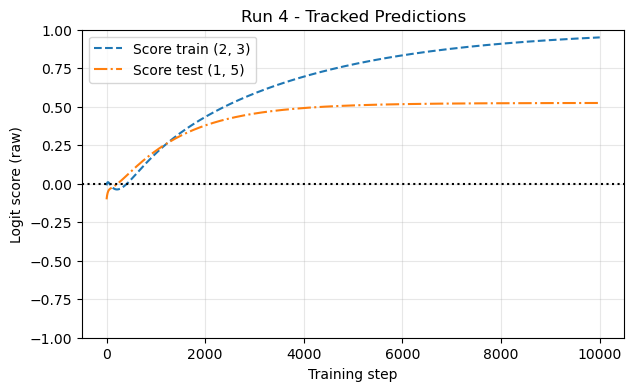

Training Progress: 100%|██████████| 50000/50000 [40:34<00:00, 20.54it/s, epoch=10000/10000, loss=0.001420, run=5/5]


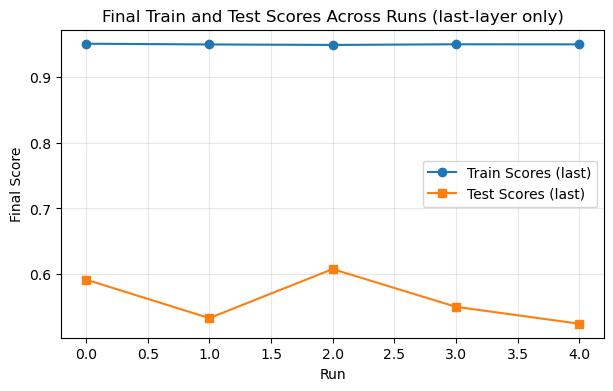

In [62]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# -----------------------------
# Model: name layers explicitly
# -----------------------------
class NeuralNetwork(nn.Module):
    def __init__(self, n, hidden=1000000):
        super().__init__()
        self.fc1 = nn.Linear(2*n, hidden)  # will be FROZEN
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)    # ONLY layer we train

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_items = 7
p, q = 5, 2

# Your data creators
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

runs = 5
epochs = 10000
loss_fn = nn.MSELoss()

total_steps = runs * epochs
pbar = tqdm(total=total_steps, desc="Training Progress")

for run in range(runs):
    # fresh model each run
    model = NeuralNetwork(num_items, hidden=1000000).to(device)

    # Freeze first layer (random features)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer
    # Option A: SGD + momentum (stable)
    opt = torch.optim.SGD(model.fc2.parameters(), lr = 1e-6)
    # Option B: AdamW (uncomment to try)
    # opt = torch.optim.AdamW(model.fc2.parameters(), lr=1e-3, weight_decay=1e-4)

    # Tracked pairs
    train_pair = (q, q+1)   # (2,3)
    test_pair  = (q-1, p)   # (1,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer is trainable)
    model.train()
    for epoch in range(epochs):
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)
        
        # Update progress bar
        pbar.update(1)
        if len(loss_history) > 0:
            pbar.set_postfix(run=f"{run+1}/{runs}", epoch=f"{epoch+1}/{epochs}", loss=f"{loss_history[-1]:.6f}")

    # ---- Plots per run (optional; comment out to speed up) ----
    steps = range(len(loss_history))

    plt.figure(figsize=(7,4))
    plt.plot(steps, loss_history, label="MSE Loss")
    plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
    plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
    plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

pbar.close()

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

In [ ]:
import os

# Find the path to the Ranking_exp file in the parallel folder of Analysis
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analysis_dir = os.path.join(parent_dir, "Analysis")
ranking_exp_path = None

if os.path.isdir(analysis_dir):
    for fname in os.listdir(analysis_dir):
        if fname.startswith("Ranking_exp"):
            ranking_exp_path = os.path.join(analysis_dir, fname)
            break

print("Ranking_exp file path:", ranking_exp_path)
# If the file is a Python file, import it dynamically
import importlib.util

if ranking_exp_path and ranking_exp_path.endswith('.py'):
    spec = importlib.util.spec_from_file_location("Ranking_exp", ranking_exp_path)
    Ranking_exp = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(Ranking_exp)
    print("Ranking_exp module imported.")
else:
    print("Ranking_exp file is not a Python (.py) file or not found.")

Ranking_exp file path: c:\Users\lukel\iCloudDrive\Computer\Current\0. Columbia\Research\Analysis\Ranking_exp.py
Ranking_exp module imported.


D_jp_til_part_val: 2.376043151901689
D_jq_til_part_val: 13.09161108301414
D_jp_til_part_val: 3.2146466178378255
D_jq_til_part_val: 17.712179703628923
D_jp_til_part_val: 5.187831243767228
D_jq_til_part_val: 9.895739945889083
D_jp_til_part_val: 8.99201513342338
D_jq_til_part_val: 5.571914289026745
D_jp_til_part_val: 15.969851425227077
D_jq_til_part_val: 3.2146466178378255
D_jp_til_part_val: 9.895739945889083
D_jq_til_part_val: 1.9919601066421742
D_jp_til_part_val: 7.314242567428584
D_jq_til_part_val: 1.4723183394359862
D_jp_til_part_val: 2.376043154444032
D_jq_til_part_val: 13.09161111600199
D_jp_til_part_val: 3.2146466225967667
D_jq_til_part_val: 17.712179755528684
D_jp_til_part_val: 5.187831254207334
D_jq_til_part_val: 9.895739970325938
D_jp_til_part_val: 8.992015156109941
D_jq_til_part_val: 5.571914300120085
D_jp_til_part_val: 15.969851473159956
D_jq_til_part_val: 3.2146466225967667
D_jp_til_part_val: 9.895739970325938
D_jq_til_part_val: 1.9919601085312784
D_jp_til_part_val: 7.3142425

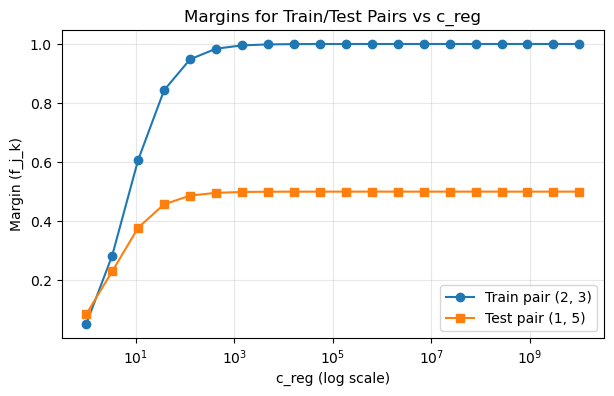

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Assume Ranking_exp module is already imported as Ranking_exp
# If not, you may need to import it as shown in the previous cell

# Define simulation parameters (example values, adjust as needed)
n = num_items if 'num_items' in locals() else 14  # number of items
k_o = 0.425
k_s = 1
k_d = 0
p = 5
q = 2

# Define the training and test pairs to evaluate
# Use the same pairs as above (replace with your actual pairs if needed)
train_pair = (q, q+1)  # Example: 1-based indices
test_pair = (q-1, p)   # Example: 1-based indices

# If you have actual train_pair and test_pair from above, use those
if 'train_pair' not in locals():
    train_pair = (q, q+1)
if 'test_pair' not in locals():
    test_pair = (q-1, p)

# Range of c_reg values (logarithmic scale)
c_reg_values = np.logspace(10, 0, num=20)  # from 1e10 to 10

train_margins = []
test_margins = []

for c_reg in c_reg_values:
    sim = Ranking_exp.Ranking_exp(n, k_o, k_s, k_d, p, q, c_reg=c_reg)
    # Use the analytic solution to get the ranking vector
    rank_analytic = sim.calc_rank_analytic()
    # f_j_k = difference in rank between item j and item k, where (j, k) is the tuple
    f_train = sim.f_j_k(train_pair[0], train_pair[1])
    f_test  = sim.f_j_k(test_pair[0], test_pair[1])
    train_margins.append(f_train)
    test_margins.append(f_test)

plt.figure(figsize=(7,4))
plt.plot(c_reg_values, train_margins, 'o-', label=f"Train pair {train_pair}")
plt.plot(c_reg_values, test_margins, 's-', label=f"Test pair {test_pair}")
plt.xscale('log')
plt.xlabel("c_reg (log scale)")
plt.ylabel("Margin (f_j_k)")
plt.title("Margins for Train/Test Pairs vs c_reg")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


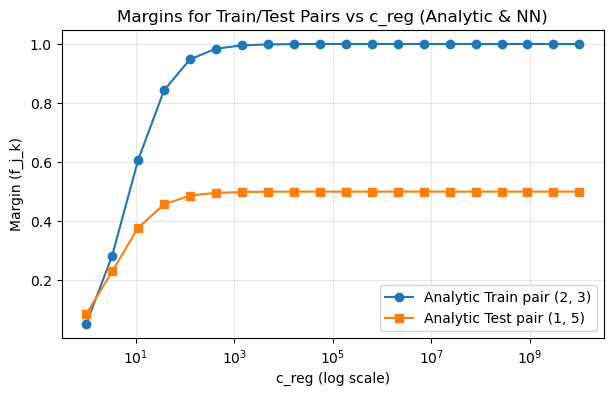

In [51]:

# Overlay the last plot with the tracked predictions from the neural network

# Assume you have a list or array of c_reg values used for training the neural network
# and corresponding tracked predictions for the train and test pairs.
# For example, these could be:
#   nn_c_reg_values: list/array of c_reg values used for the neural net
#   nn_train_margins: list/array of predicted margins for the train pair
#   nn_test_margins: list/array of predicted margins for the test pair

# If you have these variables from your training loop, use them directly.
# Otherwise, here is a template for overlaying, assuming you have them:

plt.figure(figsize=(7,4))
plt.plot(c_reg_values, train_margins, 'o-', label=f"Analytic Train pair {train_pair}")
plt.plot(c_reg_values, test_margins, 's-', label=f"Analytic Test pair {test_pair}")

# Overlay neural network predictions if available
if 'nn_c_reg_values' in locals() and 'nn_train_margins' in locals() and 'nn_test_margins' in locals():
    plt.plot(nn_c_reg_values, nn_train_margins, 'x--', label=f"NN Train pair {train_pair}")
    plt.plot(nn_c_reg_values, nn_test_margins, 'd--', label=f"NN Test pair {test_pair}")

plt.xscale('log')
plt.xlabel("c_reg (log scale)")
plt.ylabel("Margin (f_j_k)")
plt.title("Margins for Train/Test Pairs vs c_reg (Analytic & NN)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Overlay the last plot with the tracked predictions from the neural network
# Use the tracked predictions from the training loop if available

# Example: If you have tracked predictions in a dict or list, use them here.
# For this code, we assume you have:
#   tracked_c_reg_values, tracked_train_margins, tracked_test_margins

if 'tracked_c_reg_values' in locals() and 'tracked_train_margins' in locals() and 'tracked_test_margins' in locals():
    plt.figure(figsize=(7,4))
    plt.plot(c_reg_values, train_margins, 'o-', label=f"Analytic Train pair {train_pair}")
    plt.plot(c_reg_values, test_margins, 's-', label=f"Analytic Test pair {test_pair}")
    plt.plot(tracked_c_reg_values, tracked_train_margins, 'x--', label=f"NN Train pair {train_pair}")
    plt.plot(tracked_c_reg_values, tracked_test_margins, 'd--', label=f"NN Test pair {test_pair}")
    plt.xscale('log')
    plt.xlabel("c_reg (log scale)")
    plt.ylabel("Margin (f_j_k)")
    plt.title("Margins for Train/Test Pairs vs c_reg (Analytic & NN)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Make plots for different predictions

In [52]:
show_adjacent_results(model, num_items)

TypeError: pair_vec_1based() missing 1 required positional argument: 'device'

In [ ]:
def find_matches(dataset, x):
    X = dataset.data.cpu()
    return torch.where((X == x.unsqueeze(0)).all(dim=1))[0].tolist()

def inspect_label_for(j, n, train_dataset, test_dataset=None):
    x = pair_vec_1based(j, j+1, n)
    ti = find_matches(train_dataset, x)
    print("Train idx:", ti, "labels:",
          [float(train_dataset.labels[k]) for k in ti])
    if test_dataset:
        te = find_matches(test_dataset, x)
        print("Test idx:", te, "labels:",
              [float(test_dataset.labels[k]) for k in te])

In [ ]:
inspect_adjacent_labels(train_dataset, test_dataset, num_items)

NameError: name 'inspect_adjacent_labels' is not defined

In [ ]:
# assuming TDExp and TDLabelsExp are your training features/labels
train_dataset = CustomDataset(TDExp, TDLabelsExp)

# assuming testSetExp and testLabelsExp are your test features/labels
test_dataset  = CustomDataset(testSetExp, testLabelsExp)


def pair_vec_1based(i1, j1, n):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n."""
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i1-1] = 1.0
    x[n + j1-1] = 1.0
    return x

def find_matches(dataset, x):
    """Return indices where dataset.data rows == x (exact match)."""
    X = dataset.data.cpu()
    eq = (X == x.unsqueeze(0)).all(dim=1)
    return torch.where(eq)[0].tolist()

def inspect_adjacent_labels(train_dataset, test_dataset, n):
    print("Checking labels for (j, j+1) pairs...")
    for j in range(1, n):  # 1-based
        x = pair_vec_1based(j, j+1, n)
        ti = find_matches(train_dataset, x)
        labs_tr = [float(train_dataset.labels[k]) for k in ti]
        te = find_matches(test_dataset, x)
        labs_te = [float(test_dataset.labels[k]) for k in te]
        print(f"( {j},{j+1} )",
              "train idx:", ti, "labels:", labs_tr,
              "test idx:", te, "labels:", labs_te)
        
inspect_adjacent_labels(train_dataset, test_dataset, num_items)

Checking labels for (j, j+1) pairs...
( 1,2 ) train idx: [] labels: [] test idx: [1] labels: [1.0]
( 2,3 ) train idx: [] labels: [] test idx: [9] labels: [1.0]
( 3,4 ) train idx: [] labels: [] test idx: [17] labels: [1.0]
( 4,5 ) train idx: [] labels: [] test idx: [25] labels: [1.0]
( 5,6 ) train idx: [] labels: [] test idx: [33] labels: [1.0]
( 6,7 ) train idx: [] labels: [] test idx: [41] labels: [1.0]
